# Player/item embeddings in job space
Natalia Vélez, July 2020

In [ ]:
%matplotlib inline

import os,re,glob,scipy
import numpy as np
import pandas as pd

import scipy.cluster
import sklearn.metrics
import sklearn.cluster

import matplotlib.pyplot as plt
import seaborn as sns

import ohol_objects as obj
from gini import gini

from tqdm import notebook

sns.set_style('white')
sns.set_context('talk')

Load SVD features:

In [ ]:
avatar_labels = np.loadtxt('outputs/svd/input_playerIDs.txt')
avatar_labels = avatar_labels.astype(np.int)

item_labels = np.loadtxt('outputs/activity_features.txt')
item_labels = item_labels.astype(np.int)

print(avatar_labels)
print(item_labels)

Load SVD outputs:

In [ ]:
U = np.loadtxt('outputs/svd/U_hat.txt')
s = np.loadtxt('outputs/svd/s_hat.txt')
V_t = np.loadtxt('outputs/svd/Vh_hat.txt')

In [ ]:
print('Item labels: %s' % (item_labels.shape,))
print("U': %s" % (U.shape,))
print("V'^T: %s" % (V_t.shape,))

## Item embeddings

Pick top 10 dimensions:

In [5]:
n_dim = 10
V = np.transpose(V_t)
V_best = V[:, :n_dim]
V_best = pd.DataFrame(list(V_best), columns=['dim%i' % i for i in range(n_dim)])
V_best['item'] = item_labels
V_best['item'] = V_best['item'].astype(np.int)

print(V_best.shape)
V_best.head()                                             

(2991, 11)


,dim0,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,item
0,-0.080014,-0.092223,-0.101069,0.089923,-0.139159,0.175531,-0.037328,0.150713,-0.332145,0.201119,30
1,-0.041309,0.001662,-0.015590,0.019115,-0.036598,0.026409,0.013365,0.044115,-0.047157,-0.034958,31
2,-0.007991,-0.013029,-0.009253,0.013769,-0.010648,0.018867,-0.001432,0.015953,-0.033265,0.016577,32
3,-0.091688,-0.144131,-0.102342,-0.008037,-0.139263,-0.348869,0.019978,-0.011297,-0.167120,-0.011633,33
4,-0.107442,-0.092889,-0.055638,0.114728,-0.037886,0.090577,-0.001334,0.043328,-0.252778,0.104909,34


Pick the items that load most strongly on each dimension:

In [6]:
n_top = 10
top_list = []

for d in range(n_dim):
    d_label = 'dim%i' % d
    d_vals = V_best[d_label].values
    d_abs = np.abs(d_vals)
    d_idx = np.argpartition(d_abs, -n_top)[-n_top:]
    
    top_ids = item_labels[d_idx]
    top_names = [obj.obj_name(i) for i in top_ids]
    
    top_data = list(zip(top_names, d_vals[d_idx]))
    top_list.append(top_data)

In [7]:
for idx,sublist in enumerate(top_list):
    print('=== DIM%i ===' %idx)
    for item in sublist:
        print(item[0])

=== DIM0 ===
Carrot Pile
Stack of Clay Bowls
Clay Plate
Escaped Horse-Drawn Tire Cart - just released
Fertile Soil Pile
Basket
Domestic Gooseberry Bush
Clay Bowl - empty
Bowl of Gooseberries - +yum31
Partial Bucket of Water
=== DIM1 ===
Sharp Stone
Kindling
Escaped Horse-Drawn Tire Cart - just released
Floor Stakes
Flat Rock - empty
Stakes - +tool
Stone
Basket
Domestic Gooseberry Bush
Bowl of Gooseberries - +yum31
=== DIM2 ===
Fertile Soil
Basket
Fertile Soil Pile
Partial Bucket of Water
Escaped Horse-Drawn Tire Cart - just released
Shallow Tilled Row - groundOnly +biomeBlock4
Clay Bowl - empty
Bowl of Gooseberries - +yum31
Deep Tilled Row - groundOnly
Domestic Gooseberry Bush
=== DIM3 ===
Kindling
Stack of Clay Plates
Canada Goose Pond with Egg
Bowl of Gooseberries - +yum31
Wild Gooseberry Bush
Hand Cart
Partial Bucket of Water
Sharp Stone
Escaped Horse-Drawn Tire Cart - just released
Basket
=== DIM4 ===
Hand Cart
Partial Bucket of Water
Firing Forge
Basket
Clay Plate
Clay Bowl - empt

## Defining job g: A measure of specializatiotn

In [8]:
job_g = np.apply_along_axis(gini, 1, U)
print(job_g.shape)
print(np.min(job_g))
print(np.max(job_g))

(887931,)
0.009652253152552
0.4336185957846453


Plot distribution:

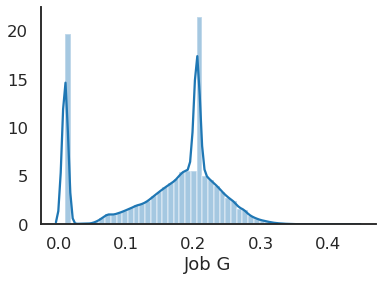

In [9]:
ax = sns.distplot(job_g)
ax.set(xlabel = 'Job G')
sns.despine()

## Job specialization over time

Family composition:

In [10]:
family_df = pd.read_csv('../2_demographics/outputs/family_generations.tsv', sep='\t')
family_df.head()

,family,avatar,gen
0,time-1584155688_eve-2783193_name-JESUS,2783193,0
1,time-1584155688_eve-2783193_name-JESUS,2783246,1
2,time-1584155688_eve-2783193_name-JESUS,2783231,1
3,time-1584155688_eve-2783193_name-JESUS,2783221,1
4,time-1584155688_eve-2783193_name-JESUS,2783313,2


Merge with job g:

In [11]:
job_df = pd.DataFrame({'avatar': avatar_labels, 'job_g': job_g})
job_df = pd.merge(job_df, family_df, on='avatar')
job_df.head()

,avatar,job_g,family,gen
0,2276905,0.237471,time-1573895755_eve-2276905_name-ZABICKI,0
1,2276906,0.224378,time-1573895755_eve-2276905_name-ZABICKI,1
2,2276909,0.167264,time-1573895755_eve-2276905_name-ZABICKI,1
3,2276911,0.227695,time-1573895904_eve-2276911_name-ROHRER,0
4,2276912,0.166453,time-1573895904_eve-2276911_name-ROHRER,1


Total # of generations per family:

In [12]:
n_gen = family_df.groupby('family')['gen'].agg('max').reset_index()
n_gen = n_gen[n_gen['gen'] > 1] # remove singletons
n_gen['log_gen'] = np.log10(n_gen['gen'])
n_gen.head()

,family,gen,log_gen
0,time-1573253679_eve-2251043_name-MCCRACKEN,2,0.301030
3,time-1573253710_eve-2251053_name-LION,3,0.477121
4,time-1573253711_eve-2251054_name-DEADRICK,6,0.778151
5,time-1573253720_eve-2251057_name-RIGHTER,6,0.778151
7,time-1573254455_eve-2251216_name-UNICK,2,0.301030


Split into quartiles:

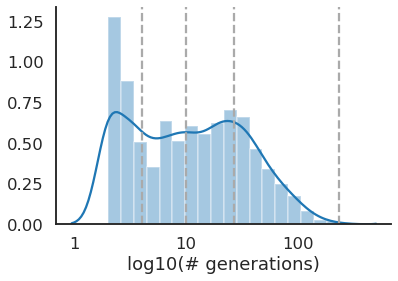

In [13]:
q_n = scipy.stats.mstats.mquantiles(n_gen['log_gen'], np.linspace(0.25,1,4))

# Plot distribution
ax = sns.distplot(n_gen['log_gen'])
ax.set(xlabel='log10(# generations)', xticks=range(3), xticklabels=[10**x for x in range(3)])
sns.despine()

for q in q_n:
    plt.axvline(q, color='#aaaaaa', linestyle='--')

Select families from each quartile:

In [14]:
n_gen['quartile'] = pd.qcut(n_gen['log_gen'], 4, labels=False)
sample_families = n_gen.copy()
sample_families = sample_families.groupby('quartile').apply(pd.DataFrame.sample, n=10)
sample_families = sample_families.reset_index(drop=True)
sample_families = sample_families[['family', 'quartile']]

print(sample_families.shape)
sample_families.head()

(40, 2)


,family,quartile
0,time-1592091591_eve-3073969_name-LOVE,0
1,time-1578957242_eve-2570513_name-CANDY,0
2,time-1581646370_eve-2692804_name-SHARP,0
3,time-1594184313_eve-3152786_name-VILLE,0
4,time-1587166704_eve-2904573_name-ROSE,0


Filter `job_df` to include only sample families:

In [15]:
job_sample = pd.merge(job_df, sample_families, on = 'family')
job_sample = job_sample.reset_index(drop=True)

print(job_sample.shape)
job_sample.head()

(6076, 5)


,avatar,job_g,family,gen,quartile
0,2284872,0.105683,time-1574046693_eve-2284872_name-LOVE,0,1
1,2284878,0.132219,time-1574046693_eve-2284872_name-LOVE,1,1
2,2284891,0.234644,time-1574046693_eve-2284872_name-LOVE,1,1
3,2284895,0.070311,time-1574046693_eve-2284872_name-LOVE,1,1
4,2284907,0.169107,time-1574046693_eve-2284872_name-LOVE,1,1


Plot mean job specialization by generation:

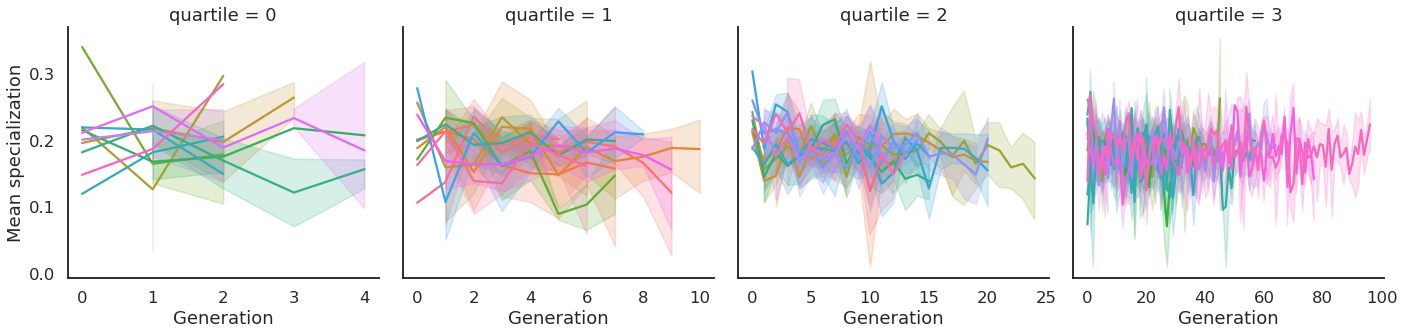

In [16]:
ax = sns.relplot(
    data=job_sample, x="gen", y="job_g",
    col="quartile", hue="family",
    kind="line", legend=False,
    facet_kws={'sharex': False}
)

ax.set(xlabel='Generation', ylabel='Mean specialization')

## Relating job g to object variety

Object variety:

In [40]:
object_variety = pd.read_csv('../5_longitudinal/outputs/object_variety.tsv', sep='\t')
object_variety = object_variety[object_variety['n_objects'] > 1]
object_variety['avatar'] = object_variety['avatar'].astype(np.int)
object_variety['log_n'] = np.log10(object_variety['n_objects'])
object_variety = pd.merge(object_variety, job_df, on='avatar')
object_variety.head()

,avatar,n_objects,log_n,job_g,family,gen
0,2276905,139,2.143015,0.237471,time-1573895755_eve-2276905_name-ZABICKI,0
1,2276906,22,1.342423,0.224378,time-1573895755_eve-2276905_name-ZABICKI,1
2,2276909,82,1.913814,0.167264,time-1573895755_eve-2276905_name-ZABICKI,1
3,2276911,25,1.397940,0.227695,time-1573895904_eve-2276911_name-ROHRER,0
4,2276912,14,1.146128,0.166453,time-1573895904_eve-2276911_name-ROHRER,1


<AxesSubplot:xlabel='log_n'>

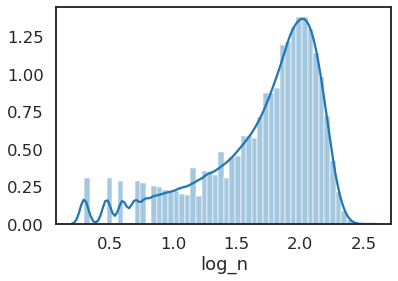

In [41]:
sns.distplot(object_variety['log_n'])

AttributeError: 'JointGrid' object has no attribute 'set'

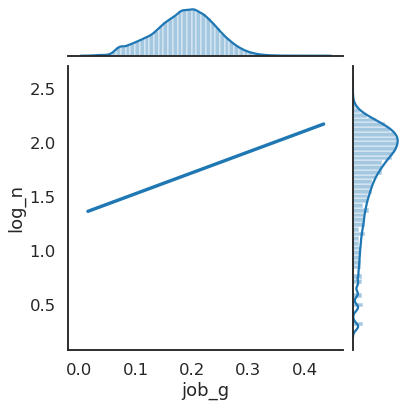

In [50]:
ax = sns.jointplot(x='job_g', y='log_n', data=object_variety, kind='reg', scatter_kws={'alpha': 0.001}) 
ax.set(xlabel = 'Job G', ylabel='log10(# objects interacted)')